In [46]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter, ImageOps
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

np.random.seed(100)
LEVEL = 'level_1'
BASE_DIR = "kaggle/input/"

no_of_rows = 3
no_of_cols = 3
column_axis=1
THRESHOLD_FOR_BINARISATION = 0.001
EPOCHS = 2728
EPOCHS = 888
LEARNING_RATE = 0.05


In [47]:
def read_all(folder_path, key_prefix="", invert_images = True):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        if invert_images:
            image = ImageOps.invert(image)
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [48]:
languages = ['ta', 'hi', 'en']

images_train = read_all(BASE_DIR+LEVEL+"_train/"+LEVEL+"/"+"background", key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all(BASE_DIR+LEVEL+"_train/"+LEVEL+"/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all(BASE_DIR+LEVEL+"_test/kaggle_"+LEVEL, key_prefix='') # change the path
print(len(images_test))

Reading:



Reading:



Reading:



Reading:



900
Reading:



300


In [49]:
list(images_test.keys())[:5]

['0', '1', '10', '100', '101']

In [50]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(900, 256) (900,)
(300, 256)


In [51]:
arr = X_train[455]
%matplotlib inline
print(arr.shape)
print(arr)
arr = arr.reshape(16,16)
from PIL import Image
im = Image.fromarray(arr)
im.show()

(256,)
[  0   8   0   3   3   9   0   8   2   2  48 240 246 112  10   0  26   0
   7  21   0   1  13   0   6  95 215  12   1 255  24  14  10  11   6   0
  11   0   0  20  37 226  16   5   0 157  64   8   3   0   1   7   4   5
  11   0  73 237   0   6  11 142  65  13   0  26   7  29   0   9  15   0
  82 147  15   0   0 255  13   3  18   3   0 217 255 237 239 255 255 237
  75  37  53 171   0   0   0   0   8 102   0  63 231 107   0  11 105   0
 153  77  17  10   6   6   0  66   0 100 255  38   5  10   3  18 252   0
   5   0   0  12   3  11   7 207 204   2   0   3   7  58 156  14   9   3
  20   0  29   0  12 200 190   5  14  24   5  78 145   0   9   0   0 159
 255 255 248 255 255 255 253 207  10 174  71  13  13   0 105 186   1   0
 110 255  46   2 123 245  44 255   1   6   0  12 198  16  13   0 205 209
   0  17 144 238  11 139   0  15   3   0 173  72   0 196 253  23   6  69
 242 145   0  88   0   0  18   0 171  72   1 168 245  38   0  78 255  80
   4  78   3   0   9   0  67 255 254 252 252

In [52]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, index, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    np.random.seed(2)
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
    
    best_w = self.w
    best_b = self.b
    min_loss = 0
    
#     if display_loss:
    loss = {}
    
#     for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
    for i in range(epochs):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
#       if display_loss:
      Y_pred = self.sigmoid(self.perceptron(X))
      if loss_fn == "mse":
        loss[i] = mean_squared_error(Y, Y_pred)
      elif loss_fn == "ce":
        loss[i] = log_loss(Y, Y_pred)
      
      if min_loss > loss[i]:
        best_w = self.w
        best_b = self.b
        min_loss = loss[i]
    
    if display_loss:
      plt.subplot(no_of_rows, no_of_cols, index)
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
#       plt.show()
    
    self.w = best_w
    self.b = best_b
    print("Successfully completed fit for K-Fold Iteration ({})".format(index))
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [53]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

C:\ML\installed_tools\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [54]:
# sn_mse = SigmoidNeuron()
# sn_mse.fit(X_scaled_train, Y_train, epochs=300, learning_rate=0.015, loss_fn="mse", display_loss=True)
# print_accuracy(sn_mse, "sn_mse")

In [55]:
# X_scaled_train.shape
# # Y_train.shape

In [56]:
X_scaled_train.shape

(900, 256)

In [57]:
Y_train.shape

(900,)

In [58]:
Y_train.reshape((len(Y_train), 1)).shape

(900, 1)

In [59]:
Y_train = Y_train.reshape((len(Y_train), 1))

In [60]:
np.unique(Y_train)

array([0, 1])

In [61]:
merged_data = np.append(X_scaled_train, Y_train, axis=1)

In [62]:
merged_data.shape

(900, 257)

In [63]:
def get_accuracy(sn, model_type, test_x, test_y):
  Y_pred = sn.predict(test_x)
  Y_pred_binarised = (Y_pred >= THRESHOLD_FOR_BINARISATION).astype("int").ravel()
  accuracy = accuracy_score(Y_pred_binarised, test_y)
  return "Accuracy: {}".format(accuracy)
  

Successfully completed fit for K-Fold Iteration (1)
Successfully completed fit for K-Fold Iteration (2)
Successfully completed fit for K-Fold Iteration (3)
Successfully completed fit for K-Fold Iteration (4)
Successfully completed fit for K-Fold Iteration (5)
Successfully completed fit for K-Fold Iteration (6)
Successfully completed fit for K-Fold Iteration (7)
Successfully completed fit for K-Fold Iteration (8)
Successfully completed fit for K-Fold Iteration (9)


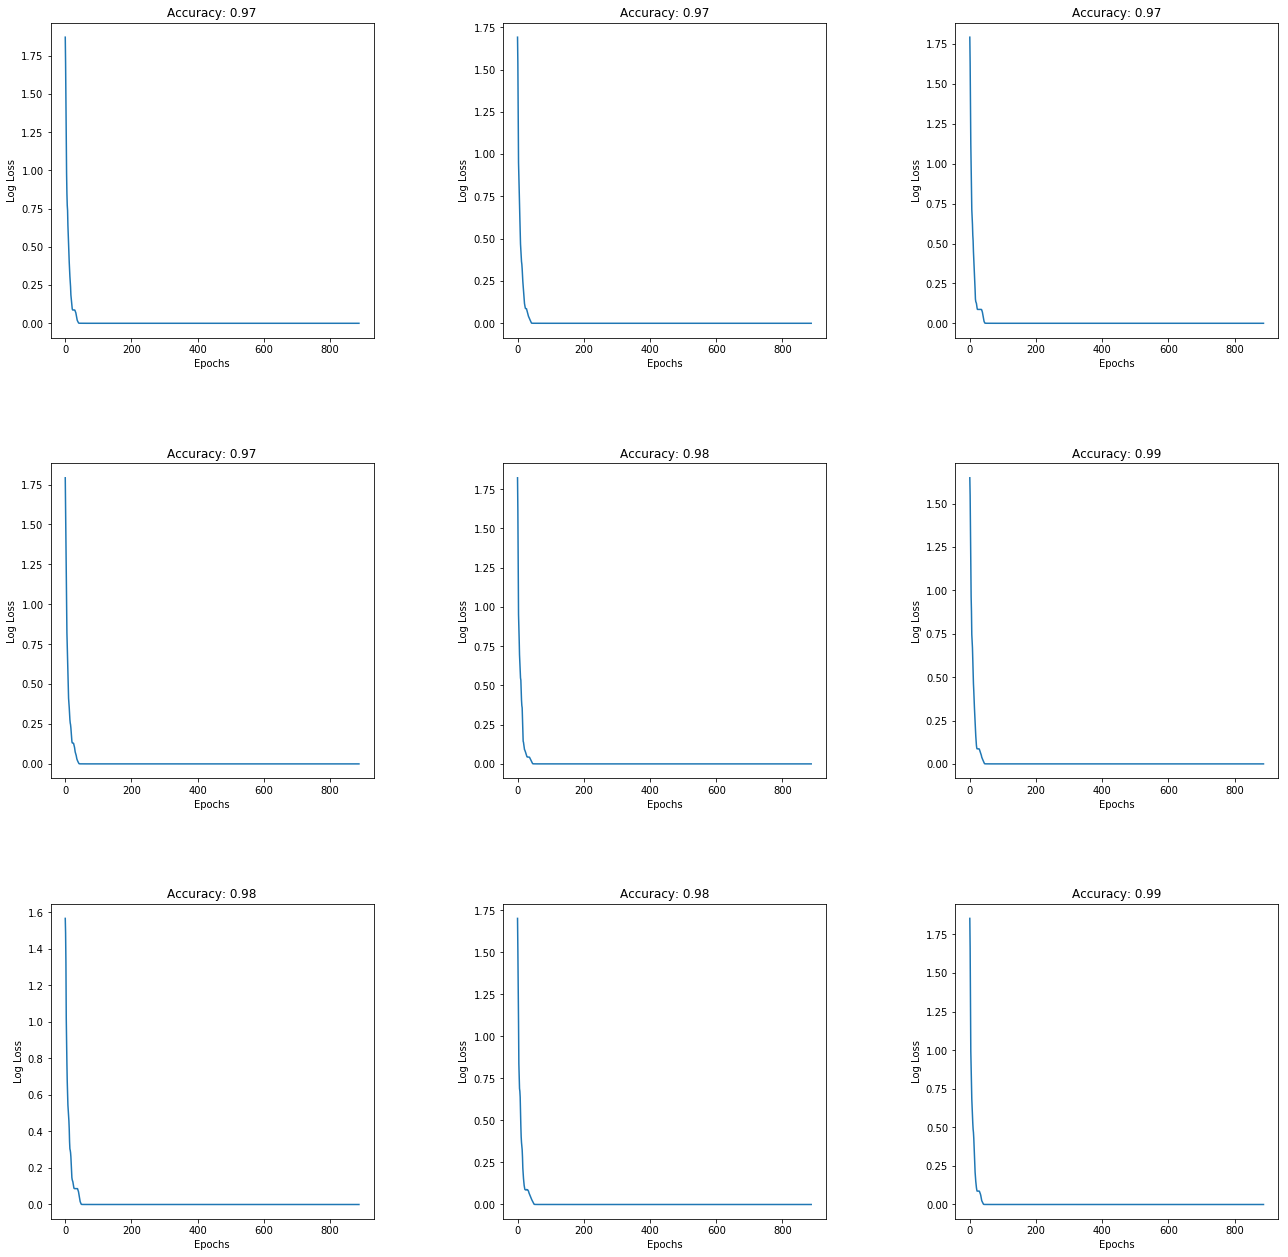

In [64]:
sn_ce = SigmoidNeuron()
# sn_ce.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="ce", display_loss=True)

kfold = KFold(9, True, 1)

plt.figure(figsize=(22, 22))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for index, kfold_split in enumerate(kfold.split(merged_data)):
    train, test = kfold_split
    X_train = np.delete(merged_data[train], -1, column_axis)
    y_train = np.delete(merged_data[train], np.s_[:-1], column_axis)
    X_test = np.delete(merged_data[test], -1, column_axis)
    y_test = np.delete(merged_data[test], np.s_[:-1], column_axis)
    sn_ce.fit(index+1, X_train, y_train, epochs=EPOCHS, learning_rate=LEARNING_RATE, loss_fn="ce", display_loss=True)
    plt.title(get_accuracy(sn_ce, "sn_ce", X_test, y_test))
plt.show()

In [65]:
sn_ce = SigmoidNeuron()
X_full = np.delete(merged_data, -1, column_axis)
y_full = np.delete(merged_data, np.s_[:-1], column_axis)
sn_ce.fit('Complete Test', X_full, y_full, epochs=EPOCHS, learning_rate=LEARNING_RATE, loss_fn="ce", display_loss=False)
print("Accuracy for Complete Test: {}".format(get_accuracy(sn_ce, "sn_ce", X_full, y_full)))

Successfully completed fit for K-Fold Iteration (Complete Test)
Accuracy for Complete Test: Accuracy: 0.98


## Sample Submission

In [66]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= THRESHOLD_FOR_BINARISATION).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)

In [67]:
# sn_ce.w